# Import Libraries

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math
import folium
from collections import defaultdict
import geopy.distance
pd.set_option('display.max_columns', 30)

In [35]:
df = pd.read_csv("../data/prepared_trips.csv").iloc[:, 1:]
stations = pd.read_csv("../data/prepared_stations.csv").iloc[:, 1:]

# 1) Servicing and Stolen/Missing Bikes
Aim: Find the bikes that need potential servicing or are missing/stolen. We assume that a bike needs servicing if it hasn't been used in a long time as it may be potentially damaged, or has been used a lot and requires inspection incase they are undergoing wear and tear. 

Guiding Questions:
- Which bike id's don't get used anymore? Why not? Can we check where these bikes are so we can service them? Or have they been stolen?
- Which bikes get used the most often? Do they need servicing ?
- When was the last time each of these bikes were used? 
- Can we track down the trip id of bikes that are potentially missing in order to track down the last rider?

### Top 10 least used bikes

In [36]:
top10_bikes_notused = df.groupby(['bikeid']).count()[['checkout_time']].sort_values(by='checkout_time', ascending=False).rename(columns={'checkout_time': 'Frequency of usage'}).tail(10)

In [37]:
top10_bikes_notused

,Frequency of usage
bikeid,
971,471
125,388
2048,247
2147,241
5089,165
851,158
488,128
172,57
988,56


In [38]:
# let us find the last time the bikes were used
top10_bikes_notused_id = top10_bikes_notused.index
bike_time = df.groupby(['bikeid']).max()[['start_time', 'duration_minutes']]
bike_time_notused = bike_time[bike_time.index.isin(top10_bikes_notused_id)]
bike_time_notused = bike_time_notused.reset_index()
bike_time_notused['bikeid'] = bike_time_notused['bikeid'].astype('str')
bike_time_notused.rename(columns={'start_time':'Last Time Used'}, inplace=True)
top10_bikes_notused = top10_bikes_notused.reset_index()
top10_bikes_notused['bikeid'] = top10_bikes_notused['bikeid'].astype('str')
top10_bikes_notused_stats = bike_time_notused.merge(top10_bikes_notused, how='left', on='bikeid')

In [39]:
top10_bikes_notused_stats

,bikeid,Last Time Used,duration_minutes,Frequency of usage
0,125,2014-08-28 11:12:00,265,388
1,172,2014-01-29 17:12:00,185,57
2,488,2015-01-24 12:12:00,402,128
3,851,2014-05-09 19:12:00,345,158
4,971,2015-05-20 14:12:00,484,471
5,987,2014-05-22 12:12:00,188,17
6,988,2014-03-15 22:12:00,253,56
7,2048,2017-07-26 11:07:45,284,247
8,2147,2017-07-31 21:57:41,401,241
9,5089,2017-03-29 09:09:27,187,165


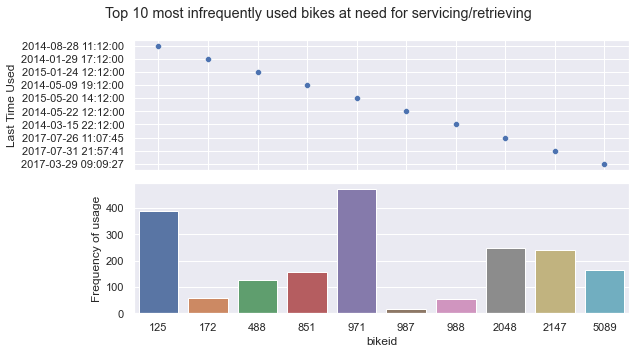

In [40]:
f, axs = plt.subplots(2,1, figsize=(9,5),sharex=True)
sns.scatterplot(data=top10_bikes_notused_stats, x='bikeid', y='Last Time Used', ax=axs[0])
sns.barplot(data=top10_bikes_notused_stats, x='bikeid', y='Frequency of usage', ax=axs[1])
plt.suptitle('Top 10 most infrequently used bikes at need for servicing/retrieving')
f.tight_layout()

From the above plot, for the upper plot, we can see that for bike id's : 125, 172, 488, 851, 971, 987, 988 need to be checked for their location and whether they are still functioning and need servicing. This is because they are the fall under the 10 least used bikes in terms of frequency of use as well as the last time they were used was quite long ago. These bike's last ride was mostly in 2014 and for bike ids 488 and 971, in 2015. The bikes that need urgent checking are bike ids: 987, 988, 172 because their values for frequency and last time of usage are especially low. 

For bike ids 2048, 2147 and 5089, though they were used recently, their frequencies of usage are low. This could mean they are new bikes that were just made. 

Intereresting enough, let us check for the top 10 most used bikes, when was the last time they were used. 

### Top 10 most frequently used bikes

In [41]:
top10_bikes_used = df.groupby(['bikeid']).count()[['checkout_time']].sort_values(by='checkout_time', ascending=False).rename(columns={'checkout_time': 'Frequency of usage'}).head(10)

In [42]:
top10_bikes_used

,Frequency of usage
bikeid,
839,2005
951,2004
696,1999
387,1991
969,1982
925,1967
885,1963
80,1936
660,1935


In [43]:
top10_bikes_used_ids = top10_bikes_used.index
top10_bikes_used = top10_bikes_used.reset_index()
top10_bikes_used['bikeid'] = top10_bikes_used['bikeid'].astype('str')
top10_bike_time = df.groupby(['bikeid']).max()[['start_time', 'duration_minutes']]
bike_time_mostused = top10_bike_time[top10_bike_time.index.isin(top10_bikes_used_ids)]
bike_time_mostused = bike_time_mostused.reset_index()
bike_time_mostused['bikeid'] = bike_time_mostused['bikeid'].astype('str')
bike_time_mostused.rename(columns={'start_time': 'Last Time Used'}, inplace=True)
top10_bikes_mostused_stats = bike_time_mostused.merge(top10_bikes_used, how='left', on='bikeid')

In [44]:
top10_bikes_mostused_stats

,bikeid,Last Time Used,duration_minutes,Frequency of usage
0,37,2017-07-24 09:31:59,490,1915
1,80,2017-07-31 12:08:00,418,1936
2,387,2017-07-31 18:46:32,590,1991
3,660,2017-07-31 13:56:47,578,1935
4,696,2017-07-31 15:43:20,574,1999
5,839,2017-07-31 21:44:13,395,2005
6,885,2017-07-29 13:25:53,466,1963
7,925,2017-07-28 15:15:30,561,1967
8,951,2017-07-30 10:26:18,550,2004
9,969,2017-07-21 20:13:02,600,1982


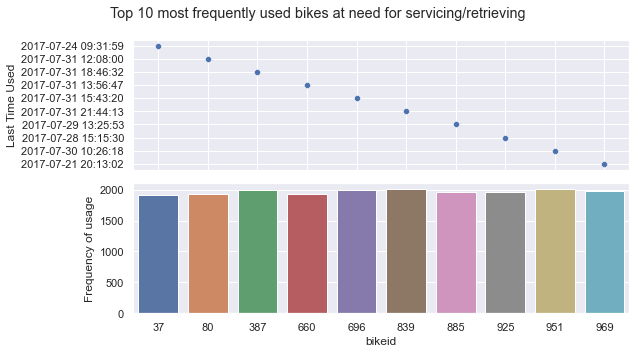

In [45]:
f, axs = plt.subplots(2,1, figsize=(9,5),sharex=True)
sns.scatterplot(data=top10_bikes_mostused_stats, x='bikeid', y='Last Time Used', ax=axs[0])
sns.barplot(data=top10_bikes_mostused_stats, x='bikeid', y='Frequency of usage', ax=axs[1])
plt.suptitle('Top 10 most frequently used bikes at need for servicing/retrieving')
f.tight_layout()

From the figure above, it seems that these bicycles get used the most frequently, and this maybe this is because they are most reliable. This also increases the chances of them requiring servicing. 

### Top 10 bikes that has a last use date to be a long time ago. 

In [46]:
top10_bikes_usedlongago = df.groupby(['bikeid']).max()[['start_time']].sort_values(by='start_time').head(10).rename(columns={"start_time": "Last Time Used"})
top10_bikes_usedlongago = top10_bikes_usedlongago.reset_index()
top10_bikes_usedlongago['bikeid'] = top10_bikes_usedlongago['bikeid'].astype('str')

[Text(0.5, 1.0, 'Top 10 bikes with the earliest last used date')]

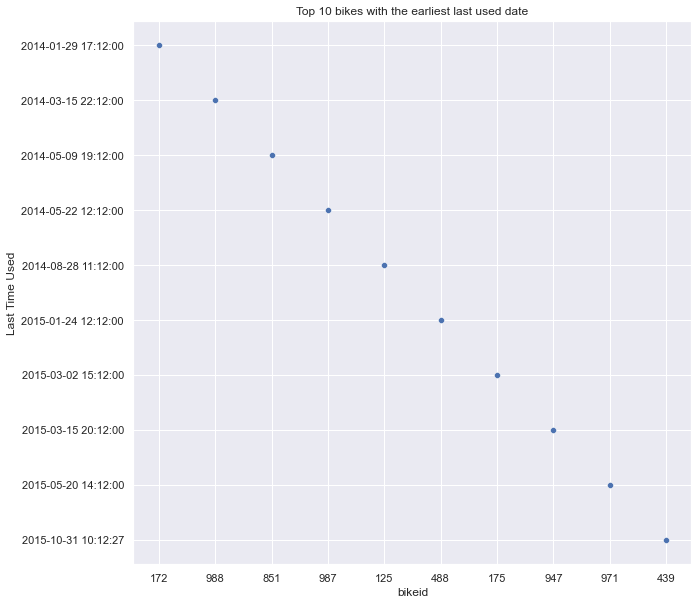

In [47]:
sns.scatterplot(data=top10_bikes_usedlongago , x='bikeid', y='Last Time Used').set(title='Top 10 bikes with the earliest last used date')

From the above plot, we can see that bike id's 172, 988, 851, 987, 125, 488, 971 are also found in our previous plot showcasing infrequent bike usage. This further supports our findings that these bike id's require servicing. Let us locate where they are.

### Bikes that need servicing locations

To find the location of these bikes, let us retrieve the coordinates of the end station they when they were last used. 

In [48]:
def get_locations(bikeids, data, category):
    locations = []
    trip_ids = []
    for bikeid in bikeids:
        lastuse_date = data[data.bikeid == str(bikeid)]['Last Time Used'].values[0]
        lat = df[(df.bikeid == bikeid) & (df.start_time==lastuse_date)].end_lat.values[0]
        long = df[(df.bikeid == bikeid) & (df.start_time==lastuse_date)].end_long.values[0]
        trip_id = df[(df.bikeid == bikeid) & (df.start_time==lastuse_date)].trip_id.values[0]
        status = df[(df.bikeid == bikeid) & (df.start_time==lastuse_date)].end_status.values[0]
        locations.append((bikeid, (lat, long), category, status))
        trip_ids.append(trip_id)
    return trip_ids, locations
bikeids1 = [172, 988, 851, 987, 125, 488, 971]
bikeids2 = top10_bikes_mostused_stats.bikeid.astype(int).to_list()
unused_trip_ids, unused_bikes_locations = get_locations(bikeids1, top10_bikes_notused_stats, 'Infrequently Used')
mostused_trip_ids, mostused_bikes_locations = get_locations(bikeids2, top10_bikes_mostused_stats, 'Frequently Used')

unused_bikes_coords = np.array([i[1] for i in unused_bikes_locations])
mostused_bikes_coords = np.array([i[1] for i in mostused_bikes_locations])
mean_lat = (np.mean(unused_bikes_coords, axis=0)[0] + np.mean(mostused_bikes_coords, axis=0)[0])/2
mean_long = (np.mean(unused_bikes_coords, axis=0)[1] + np.mean(mostused_bikes_coords, axis=0)[1])/2

mostused_bikes_locations.extend(unused_bikes_locations)
seen = defaultdict(lambda: 0)
for bid, coord, cat, status in mostused_bikes_locations:
    seen[coord] += 1
res = []
for bid, coord, cat, status in mostused_bikes_locations:
    get_freq = seen[coord]
    if get_freq == 1:
        res.append((str(bid), coord, cat, status))
    else:
        bids = ''
        latest_cat = ''
        for bid2, coord2, cat2, status2 in mostused_bikes_locations:
            if coord == coord2:
                bids += str(bid2) + ', '
                latest_cat = cat2
        if (bids, coord, latest_cat) not in res:
            res.append((bids, coord, latest_cat, status2))

In [49]:
bike_map = folium.Map(location=[mean_lat, mean_long], 
                 zoom_start=14, 
                 control_scale=True)
for bikeid, coord, category, status in res:
    if ',' in bikeid:
        bikeid = bikeid[:-2]
    if status == 'active':
        if category == 'Frequently Used':
            color = 'blue'
        else:
            color = 'red'
    else:
        color = 'purple'
        
    folium.Marker(location=[coord[0], coord[1]], popup=bikeid, icon=folium.Icon(color=color)).add_to(bike_map)
bike_map    

Note: To interact with the map, please download this notebook. 
- Each marker in the above map is a station, and if you click on the marker, it showcases the bike ids found at that station. From the above map, we can see that bike's that require urgent inspection are located at stations indicated by the red markers. These bikes fall under being used a long time ago and also do not have many rides. 

- The blue markers represent the stations containing bikes that are used very frequently, and require regular inspections to make sure they do not require any servicing. Some stations have multiple bike's located in them, and for red markers, there is at least 1 bike that has not been frequently used. It is also possible that frequently used bikes are located at stations with the red markers. 

- For the purple marker, that station has closed, and this means the bike has gone missing. The relevant authorities should track down the missing bike. 

### The trip id of the rarely used bikes, incase the bikes are no longer located at these stations. 

In [50]:
unused_trip_ids

[9900003167,
 9900054763,
 9900128382,
 9900133948,
 9900223362,
 9900008529,
 9900148557]

With these trip id's, it maybe possible to locate the user or the account of the rider that last used this bike, incase this bike got stolen. 

Key Finding 1: We found the potential bikes that require servicing based on their frequency of trips as well as the last time they were rode, and the stations they were last parked in. Relevant authorities need to visit these stations to check whether these bikes are still there or have they disappeared. We know that bike id: 172 has definitely gone missing because the last station it was parked in has been closed. 

# 2) Fulfilling demand at different times and locations

Aim: To fullfill demands, we need to find out which months, days of the month, days of the week, weekend/weekday, hour of the day were the most popular. We also need to find out which stations had the highest traffic of bikes coming in and out. Based on these results, we can get an idea on when the demand is high/low for bikes. 

Guiding Questions:
- What is the busiest month of the year?
- What is the busiest day of the month?
- What is the busiest day of the week?
- Are weekends or weekdays busier?
- What is the busiest hour of the day?
- Which station sees the highest traffic of bikes coming in and out? traffic = (number of trips that start + number of trips that end at that station) / number of days there was at least 1 trip at that station.
- For this station, at which hours do people take and return bikes?

### Busiest Month of the year

In [51]:
year_14 = df[df.year==2014].groupby(['month']).count()[['bikeid']].rename(columns={'bikeid':'count'}).reset_index()
year_14['year'] = '2014'

year_15 = df[df.year==2015].groupby(['month']).count()[['bikeid']].rename(columns={'bikeid':'count'}).reset_index()
year_15['year'] = '2015'

year_16 = df[df.year==2016].groupby(['month']).count()[['bikeid']].rename(columns={'bikeid':'count'}).reset_index()
year_16['year'] = '2016'

year_17 = df[df.year==2017].groupby(['month']).count()[['bikeid']].rename(columns={'bikeid':'count'}).reset_index()
year_17['year'] = '2017'

years = pd.concat([year_14, year_15, year_16, year_17], axis=0)
years['month'] = years['month'].astype('category') 
years = years.reset_index()

[Text(0.5, 1.0, 'Monthly Number of Trips')]

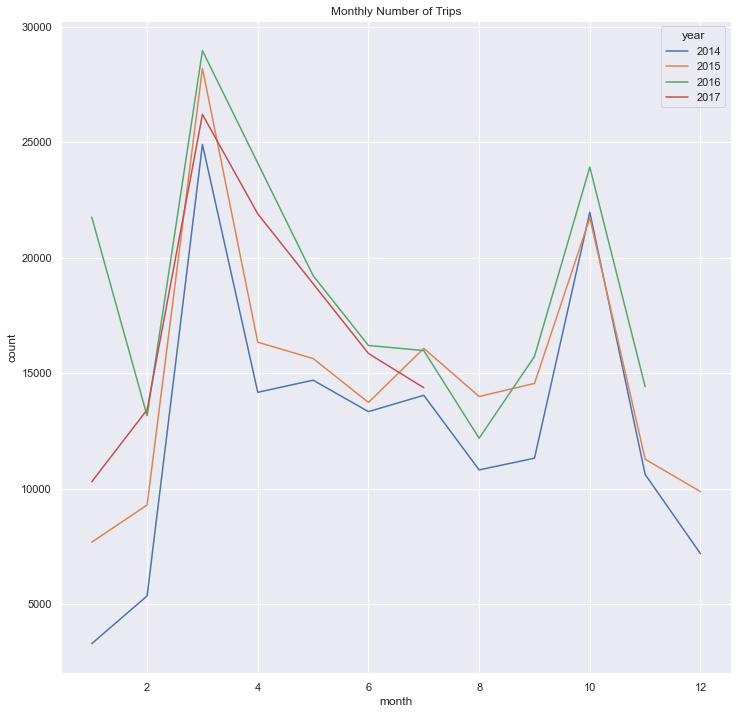

In [52]:
sns.set(rc={'figure.figsize':(12,12)})
sns.lineplot(data=years, x='month', y='count', hue='year').set(title='Monthly Number of Trips')

From the above plot, we can see that the months of October and March are the busiest periods where customers use the bikes most frequently. Searching through the web, it showcases that Austin City Limits Music Festival (ACL ML) falls on October and must be a factor in such high demand of bikes. Therefore, we would also expect stations that are open on ACL days to see high traffic. We can investigate this later. 

In March, South by Southwest (SXSW) which is a music and film festival, takes place in Austin yearly and could be one the of the leading causes in such a high demand of bicycles. 

The least busiest period is during December, and this is to be expected since most people are possibly travelling then or due to bad weather conditions, not many people would be cycling outside. 

### Busiest and emptiest days of the month

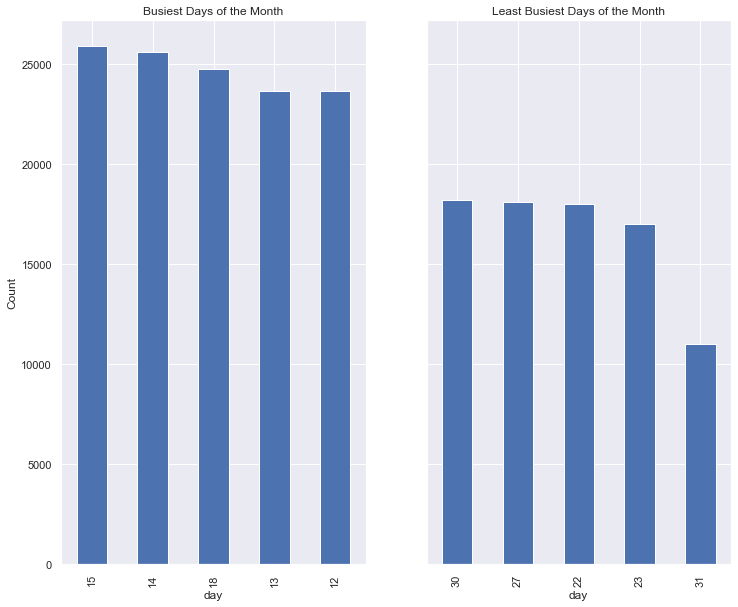

In [53]:

f, axs = plt.subplots(1,2, figsize=(12,10),sharey=True)
df.groupby(['day']).count()[['bikeid']].sort_values(by='bikeid', ascending=False).head().plot(kind='bar', ylabel = 'Count', legend=False, ax=axs[0], title='Busiest Days of the Month')
df.groupby(['day']).count()[['bikeid']].sort_values(by='bikeid', ascending=False).tail().plot(kind='bar', ylabel = 'Count', legend=False, ax=axs[1], title='Least Busiest Days of the Month')
plt.show()


We see that the 14th and 15th are the busiest days of the month, and the 31st has the lowest number of trips across the years. We can also roughly see that the busiest period the months are during the middle of the month.  

### Busiest Day of the week. 

<AxesSubplot:title={'center':'Busiest days of the week'}, ylabel='dayofweek'>

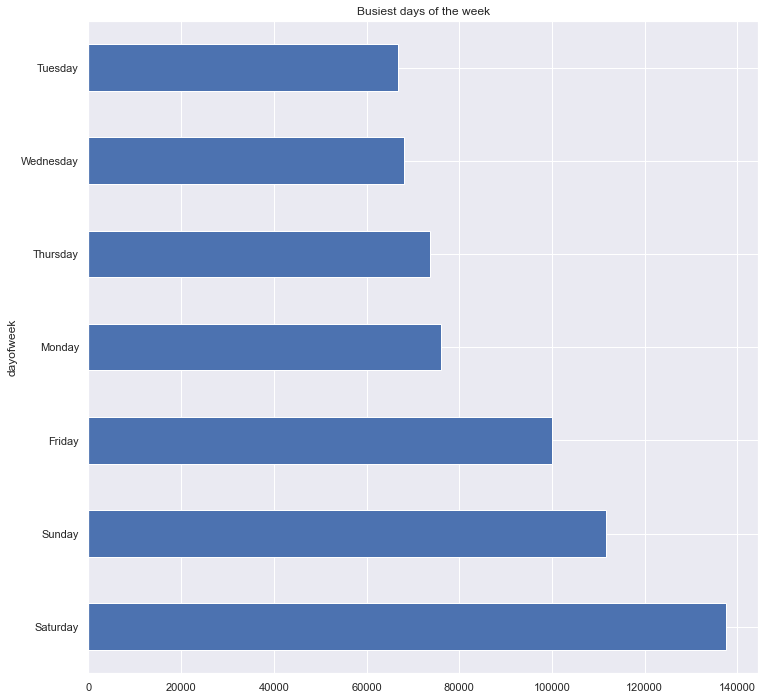

In [54]:
df.groupby(['dayofweek']).count()[['bikeid']].sort_values(by='bikeid', ascending=False).rename(columns={'bikeid':'count'}).plot(kind='barh', legend=False, title='Busiest days of the week')

The busiest days are the weekend, which is an interesting observation that stakeholders can take into account. It could be possible that most people use bikes during the weekend for leisure, rather than during the weekdays where they would use other forms of transport, maybe to get to work. 

### Busiest hour of the day

Because busy hours can differ based on whether the day is a weekday or not, we shall split the analysis up. 

In [55]:
busy_hours = df.groupby(['isweekend', 'hour']).count()[['bikeid']].reset_index().rename(columns={'bikeid':'count'})

[Text(0.5, 1.0, 'Busiest Hours of the Day')]

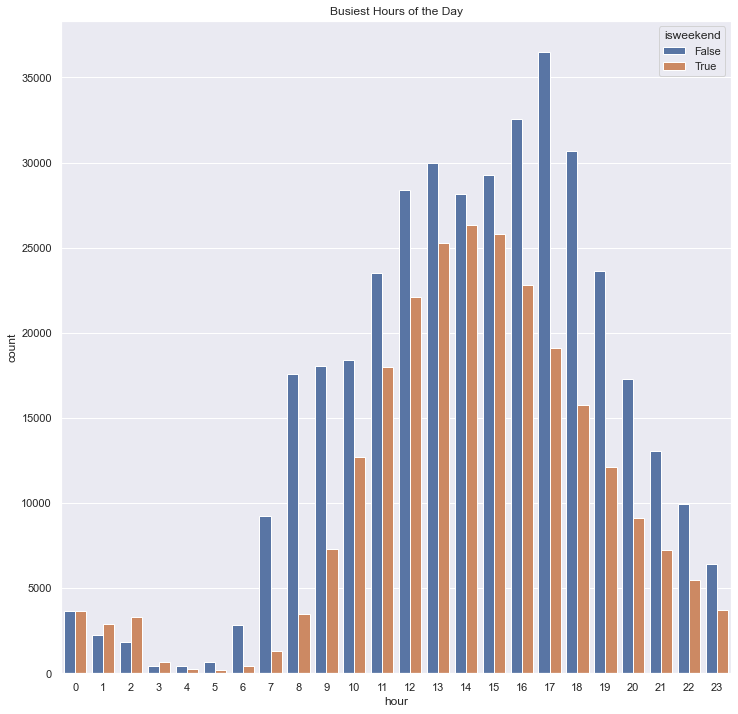

In [56]:
sns.barplot(data=busy_hours, x='hour', y='count', hue='isweekend').set(title='Busiest Hours of the Day')

For both weekend and weekday bike rides, the are most popular approximately during 1400 hours and 1700 hours respectively. 
The difference between people using bikes for the weekday and the weekend is especially significant during the earlier hours of the day (before work) and during the evening (after work). For example, hours 0600 -> 0900 and 1700 -> 1900 hours see a huge difference between weekday and weekend counts compared to other hours.
This means that during the weekday, the demand for bikes is higher during the earlier hours and later hours of the day as that is when people go to and come from work. For weekends, most people use bike rides for leisure activities, and we can see that they are mostly conducted during the afternoon/middle part of the day. 

Based on the all the above analysis, we can recommend to stakeholders the most frequent periods, and perhaps with this information, they can ensure more bikes are available during those periods. 

### Busiest Stations

- stations that see the most traffic.
- traffic = number of bikes going and coming / total number of days it's been active. 
We do this because stations that opened later may not have a fair chance of being spotted. 

<AxesSubplot:xlabel='traffic_density', ylabel='name'>

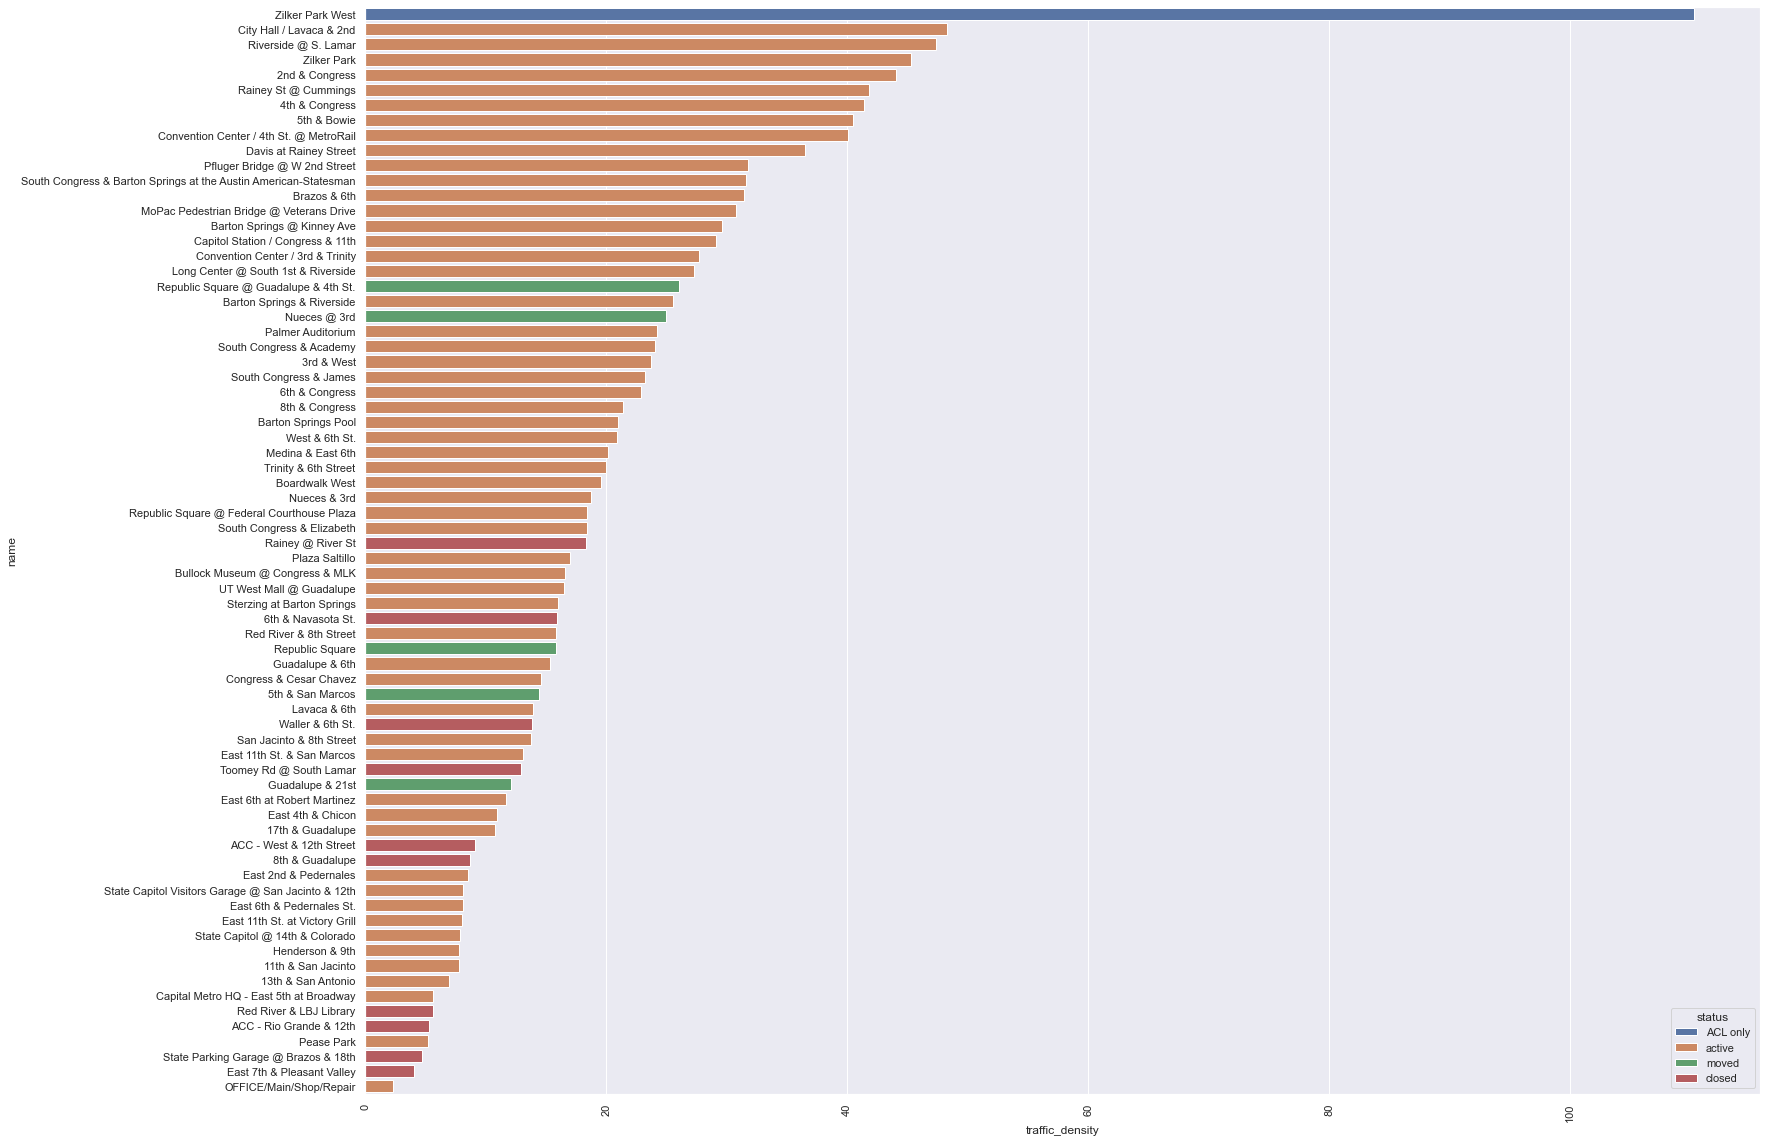

In [57]:
sns.set(rc={'figure.figsize':(25, 20)})
plt.xticks(rotation=90)
sns.barplot(data=stations.sort_values(by='traffic_density', ascending=False), x='traffic_density', y='name', hue='status', dodge=False)

We can see that the station that saw the most traffic was Zilker Park West (station id = 1006). This is to be expected as Zilker Park West caters specifically to ACL, and it is no surprise that given the number of days it's been active, there has been many riders to and from it. Other than Zilker Park West, we see that City Hall / Lavaca & 2nd (station id = 2499) see's the most traffic on general days. 

Let's do a deep dive into Zilker Park West. 

In [58]:
acl_start_hours = df[df.start_station_id == 1006].groupby(['hour']).count()[['bikeid']].rename(columns={'bikeid':'count'}).reset_index()
acl_end_hours = df[df.end_station_id == 1006].groupby(['hour']).count()[['bikeid']].rename(columns={'bikeid':'count'}).reset_index()
acl_start_hours['hour'] = acl_start_hours['hour'].apply(lambda x: 24 if x == 0 else x)
acl_end_hours['hour'] = acl_end_hours['hour'].apply(lambda x: 24 if x == 0 else x)
acl_hours = acl_start_hours.merge(acl_end_hours, on='hour', how='outer').fillna(0)
acl_hours = acl_hours.rename(columns={'count_x': 'start', 'count_y': 'end'})
acl_pivot = pd.melt(acl_hours, id_vars=['hour'],  value_vars=['start', 'end'], var_name='Type of ride', value_name='Number of Rides')
acl_pivot['Number of Rides'] = acl_pivot['Number of Rides'].astype(int)

[Text(0.5, 1.0, 'Number of bikes coming in and leaving per hour for ACL Event')]

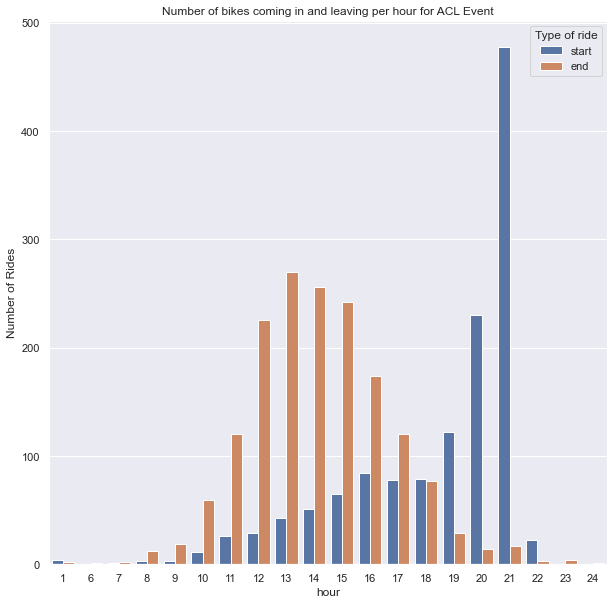

In [59]:
sns.set(rc={'figure.figsize':(10,10)})
sns.barplot(data=acl_pivot, x='hour', y='Number of Rides', hue='Type of ride').set(title="Number of bikes coming in and leaving per hour for ACL Event")

This is a very interesting graph, as we can see that for the past ACL events, most people arrive to the station around 12 pm -> 3pm, and this is when the bike station starts to get full. I would assume that the station needs to also have enough space for the bikes to be parked, if not customers would need to park elsewhere. Next, most of the visitors to ACL leave starting from 8pm and mainly 9pm. There need's to be enough bikes for customers to use for these 2 hours. I suggest employees/stakeholders of the bike company could take bikes from the nearby stations and provide them to Zilker Park West. These stations would be:

Closest Bike Stations to Zilker Park West. 

In [60]:
curr_lat = stations[stations.station_id == 1006].latitude.values[0]
curr_long = stations[stations.station_id == 1006].longitude.values[0]
acl_coord = (curr_lat, curr_long)
def get_closest_station(lat, long):
    coord = (lat, long)
    res = geopy.distance.geodesic(acl_coord, coord).km
    return res
closest_to_acl = stations.copy()
closest_to_acl['distance_to_acl_event'] = stations.apply(lambda x: get_closest_station(x.latitude, x.longitude), axis=1)
closest_to_acl = closest_to_acl.sort_values(by='distance_to_acl_event').head(4)[['latitude', 'longitude', 'name', 'status']]

In [61]:
acl_map = folium.Map(location=[mean_lat, mean_long], 
                 zoom_start=14, 
                 control_scale=True)
for lat, long, name, status in np.array(closest_to_acl):
    if status == 'active':
        color = 'blue'
    else:
        color = 'purple'
        
    folium.Marker(location=[lat, long], popup=name, icon=folium.Icon(color=color)).add_to(acl_map)
acl_map    

The 3 closest stations to Zilker Park West: 
- Zilker Park (3rd Highest Dense Location)
- Barton Springs Pool (Low Desity)
- Sterzing at Barton Springs (Low Desity)

Key Finding 2: We have found the various busy periods of the month, week and day. We have also found out that the ACL event which is closest to Zilker Park West causes Zilker Park West to see the highest traffic of incoming and outgoing bikes. Hence for this event, stakeholders could plan in advance on how to ensure there are sufficient bikes and bike spaces at that station. They can look at which hours people come and go, and decide based on that when to supplement and remove bicycles.

# 3) Subscriber Type - How to generate more profits from Subscribers?
Aim: We want to study the behaviours of subscribers and determine how we can maximize profits from our most common subscribers.

Guiding Questions:
- Who are the most frequent users of the bikes?
- How do they behave during different hours of the day?
- How long do they ride the bike for?

### Most Common Subs

In [62]:
top5_subs = df.groupby(['subscriber_type'], as_index=True).count()[['bikeid']].rename(columns={'bikeid': 'count'}).sort_values(by='count', ascending=False).head()

<AxesSubplot:title={'center':'Top 5 most common subscribers'}, xlabel='subscriber_type', ylabel='Count'>

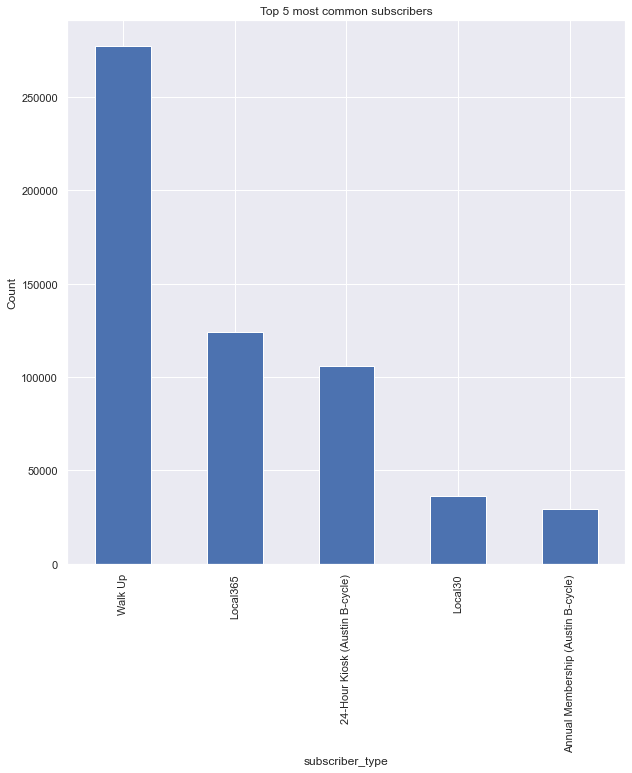

In [63]:
top5_subs.plot(kind='bar', legend=False, ylabel='Count', title='Top 5 most common subscribers')

There are significantly more walk up subscribers than any other type of subscriber. This is not unexpected as most people could be using these bikes for leisure. We are now interested to see how walk up subscribers (short term subscribers) behave during the weekdays and weekends vs local365 and annual membership subscribers (long term subscribers). Let us now scrutinize the behaviour of these groups.

### Walk up

In [64]:
walkup = df[df.subscriber_type=='Walk Up']
walkupg = walkup.groupby(['hour', 'isweekend']).count()[['bikeid']].rename(columns={'bikeid':'count'}).reset_index()

Local365 = df[df.subscriber_type=='Local365']
Local365g= Local365.groupby(['hour', 'isweekend']).count()[['bikeid']].rename(columns={'bikeid':'count'}).reset_index()

annual = df[df.subscriber_type=='Annual Membership (Austin B-cycle)']
annualg = annual.groupby(['hour', 'isweekend']).count()[['bikeid']].rename(columns={'bikeid':'count'}).reset_index()

[Text(0.5, 1.0, 'Annual Hourly Breakdown')]

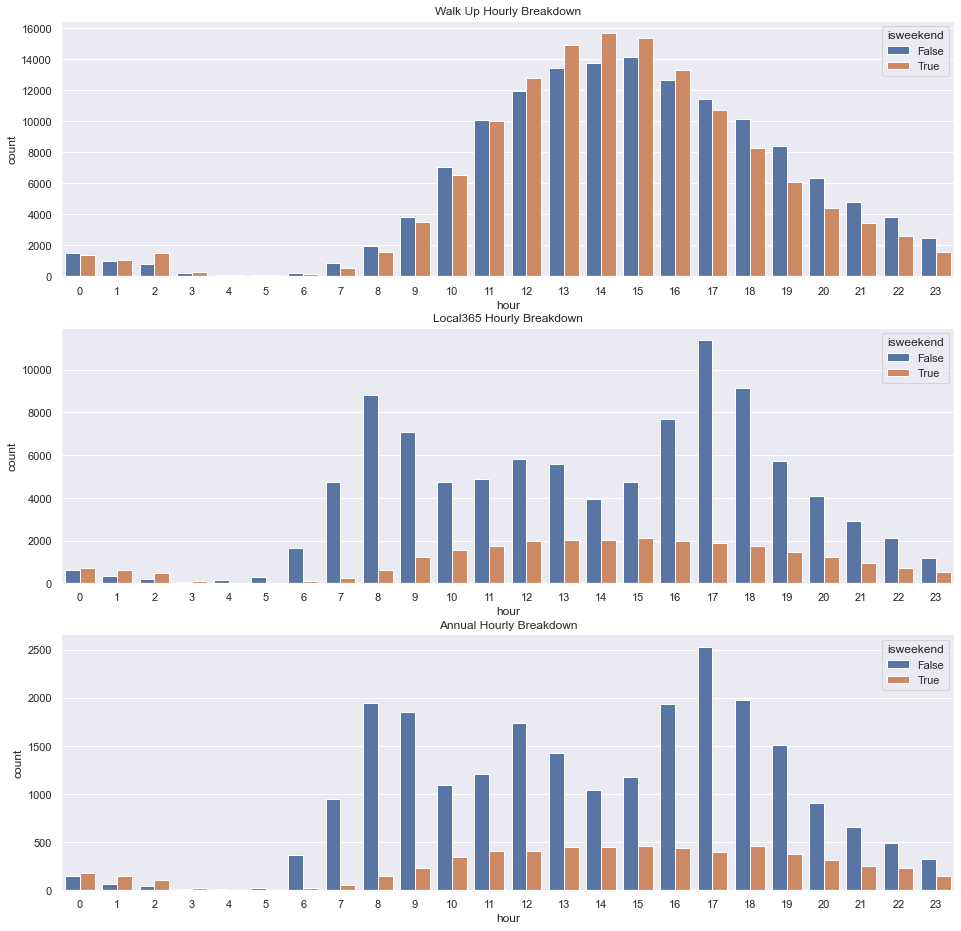

In [65]:
fig, ax = plt.subplots(3,1,figsize=(16,16))
sns.barplot(ax=ax[0], x='hour', y='count', data=walkupg, hue='isweekend').set(title="Walk Up Hourly Breakdown")
sns.barplot(ax=ax[1], x='hour', y='count', data=Local365g, hue='isweekend').set(title="Local365 Hourly Breakdown")
sns.barplot(ax=ax[2], x='hour', y='count', data=annualg, hue='isweekend').set(title="Annual Hourly Breakdown")

Let us also look at trip duration:

<AxesSubplot:xlabel='subscriber_type', ylabel='duration_minutes'>

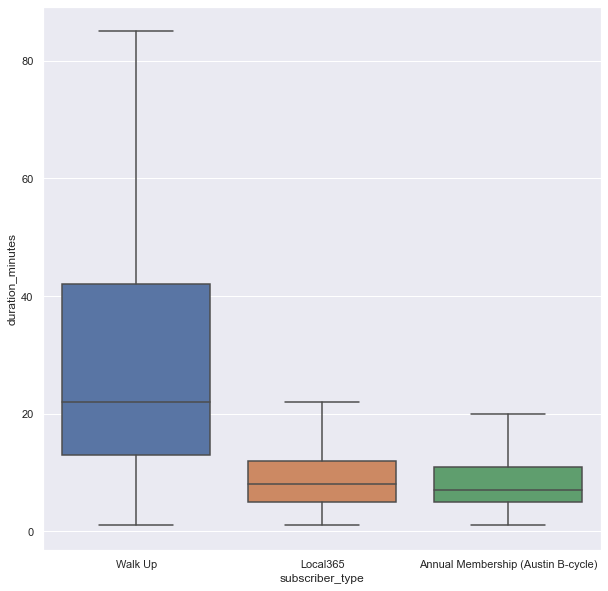

In [66]:
subs = df[df.subscriber_type.isin(['Walk Up', 'Local365', 'Annual Membership (Austin B-cycle)'])]
sns.boxplot(data=subs, x='subscriber_type', y='duration_minutes',  showfliers = False)

Key Findings:
- Walk up people ride longer and it makes sense because they ride more during weekends and its for leisure compared to longer term subscribers who ride for work purposes and more often during weekdays.  

- Walk up mostly ride during weekends, and stakeholders could come up with solutions to convince them to ride more during weekdays. For example, incentivize Walk Up riders by showcasing discounts and promotions exclusively to get them to join longer term memberships, and try to get them to cycle to work. 

- And the opposite is true for the long term subscribers. They tend to cycle during weekdays, and it's most probably for work as seen by the plots. This would mean that stakeholders could come up with incentives for them to ride during the weekend where they would could have longer rides. 